**Import Important Libraries**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn import preprocessing

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
from sklearn.impute import SimpleImputer

In [15]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

**Data Collection**

In [6]:
train = pd.read_csv('../data/raw/train.csv')
test  = pd.read_csv('../data/raw/test.csv')

**Statistical Summary**

In [ ]:
train.describe()

In [ ]:
train.info()

In [ ]:
# train_numerical_features   = train.select_dtypes(exclude='object')
# train_categorical_features = train.select_dtypes(include='object')

In [ ]:
#list of columns that are categorical
# cat_f = list(train_categorical_features.columns)

**Data Cleaning**

*Missing Data Imputation*

In [7]:
train_data_v1 = train

In [8]:
nullseries = train_data_v1.isnull().sum().sort_values(ascending=False)
nullseries[nullseries > 0]

team2_other_raw_var_19              20453
team1_other_raw_var_50              20453
team1_other_raw_var_72              20453
team1_other_raw_var_19              20453
team1_other_raw_var_31              20453
                                    ...  
player_offensive_derived_var_21        75
player_positional_derived_var_22       75
player_offensive_derived_var_24        75
player_height                           2
player_weight                           2
Length: 788, dtype: int64

In [9]:
#import pandas as pd

def delete_missing_value_columns(df, threshold=0.7):
    """
    Delete columns from a DataFrame if the missing value percentage is greater than a threshold.

    Parameters:
    df (pandas.DataFrame): The DataFrame to delete columns from.
    threshold (float, optional): The maximum missing value percentage allowed before a column is deleted.
                                 Default is 0.7.

    Returns:
    pandas.DataFrame: The DataFrame with columns deleted.
    """
    # Calculate the missing value percentage for each column
    missing_values = df.isnull().mean()

    # Identify the columns where the missing value percentage is greater than the threshold
    columns_to_delete = missing_values[missing_values > threshold].index.tolist()

    # Delete the identified columns
    df = df.drop(columns_to_delete, axis=1)

    return df


In [10]:
train_data_v2 = delete_missing_value_columns(train_data_v1)

In [11]:
def impute_features(df):
    """
    Impute missing values in continuous and categorical features using SimpleImputer
    
    Args:
    - df: Pandas DataFrame with continuous and categorical features
    - strategy: string, strategy to use for imputation (default: 'median')
    
    Returns:
    - Pandas DataFrame with imputed values
    """
    # identify continuous and categorical columns
    cont_cols = df.select_dtypes(include=np.number).columns
    cat_cols = df.select_dtypes(exclude=np.number).columns
    
    # impute missing values in continuous columns
    cont_imputer = SimpleImputer(strategy='median')
    df[cont_cols] = cont_imputer.fit_transform(df[cont_cols])
    
    # impute missing values in categorical columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    
    return df


In [12]:
train_data_v3 = impute_features(train_data_v2)

***Feature Scaling***

In [13]:
def scale_continuous_features(df):
    """
    Scales the continuous variables in a dataframe using the scikit-learn StandardScaler.

    Args:
        df (pandas.DataFrame): The dataframe to scale.

    Returns:
        pandas.DataFrame: The scaled dataframe.
    """
    # Extract the continuous features
    continuous_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()
    if len(continuous_cols) == 0:
        print("No continuous features found in dataframe.")
        return df

    # Scale the continuous features
    scaler = StandardScaler()
    df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

    return df


In [16]:
train_data_v4 = scale_continuous_features(train_data_v3)

**Encode Features and Feature Selection and Feature Engineering**

In [17]:
from featurewiz import featurewiz

Imported 0.2.04 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (20453, 746)
#### Single_Label Multi_Classification problem ####
loading the entire test dataframe - there is no nrows limit applicable #########
    Loaded test data. Shape = (8774, 799)
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Multi_Classification problem ####
    loading a random sample of 10000 rows into pandas for EDA
#################

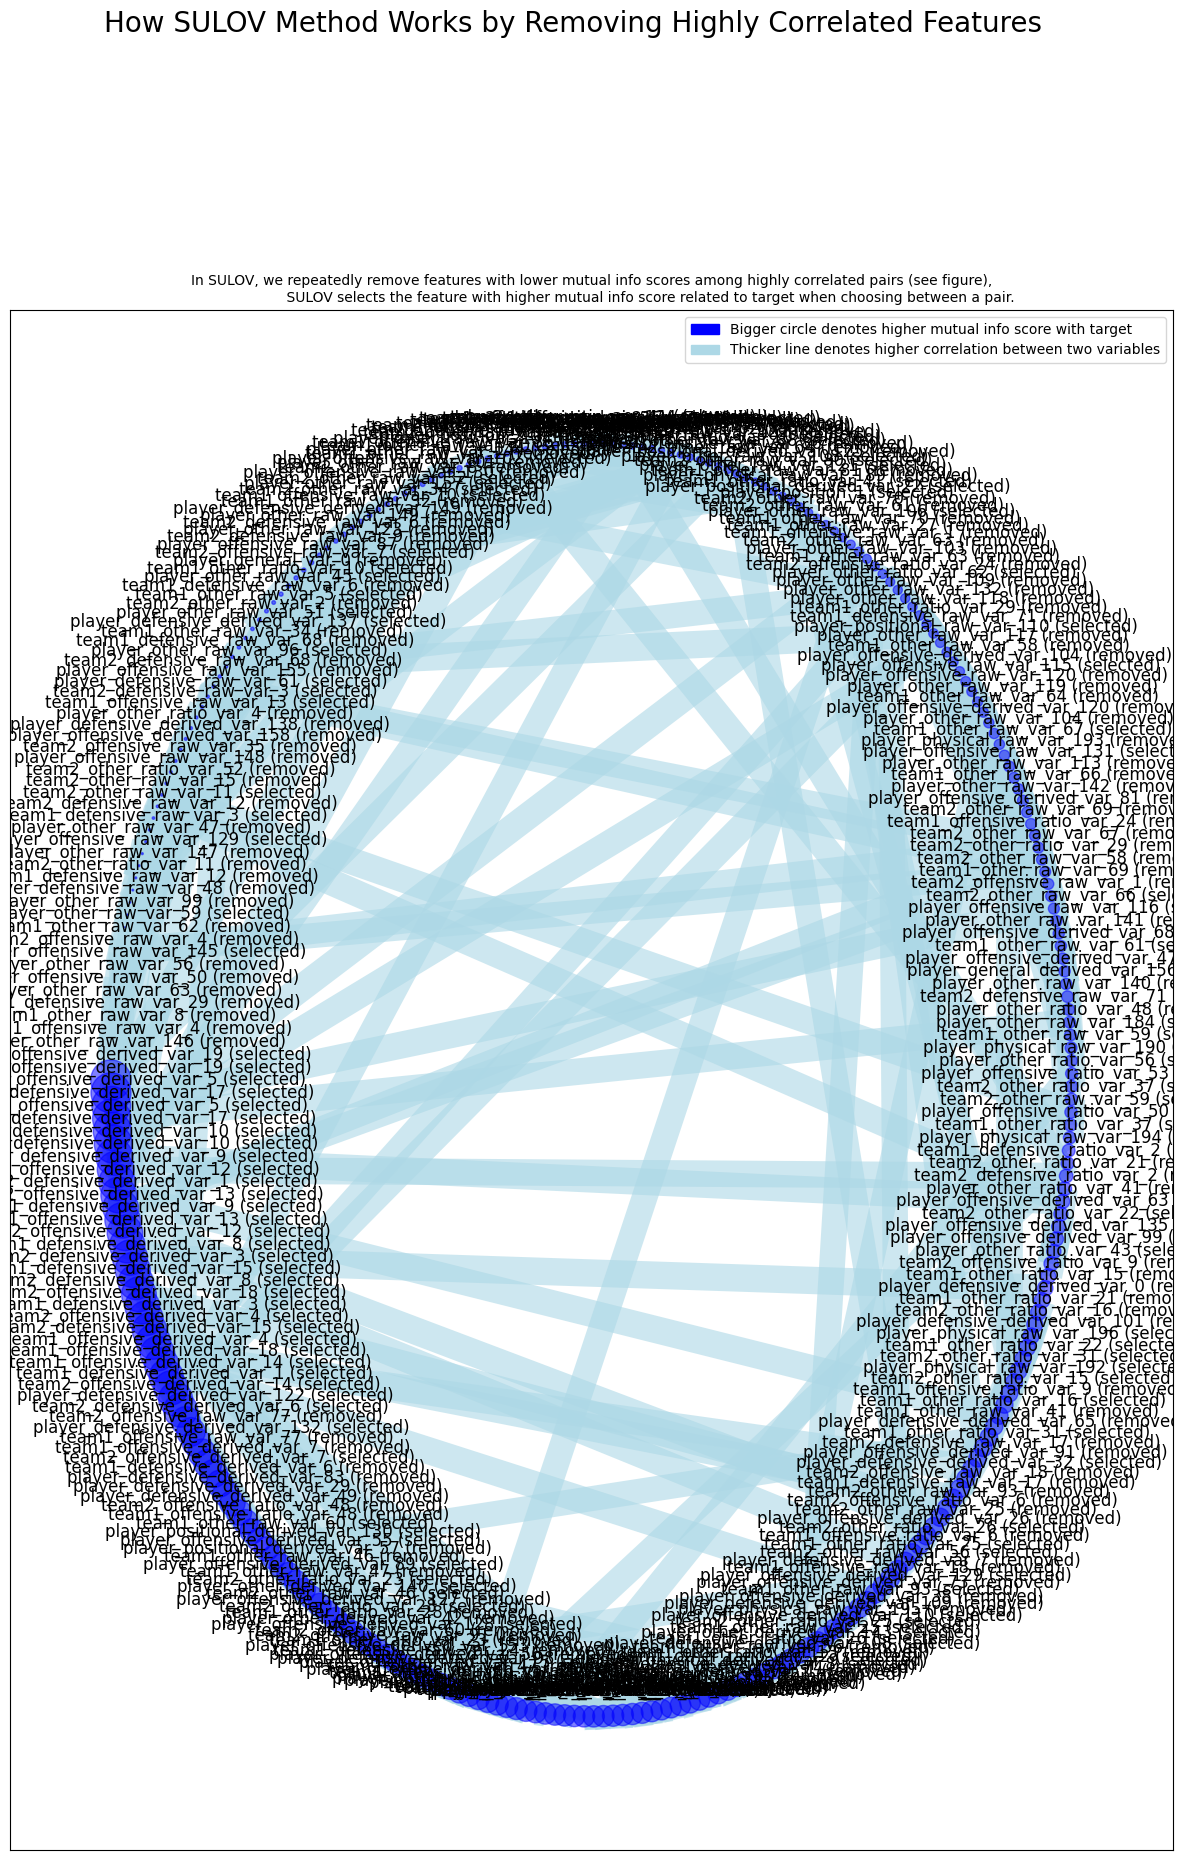

Time taken for SULOV method = 223 seconds
    Adding 0 categorical variables to reduced numeric variables  of 1300
Finally 1300 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Since  category encoding is done, dropping original categorical vars from predictors...
Current number of predictors before recursive XGBoost = 1300 
    Taking top 221 features per iteration...
    XGBoost version using 1.7.3 as tree method: hist
Number of booster rounds = 100
        using 1300 variables...
            selecting 247 features in this iteration
            Time taken for regular XGBoost feature selection = 99 seconds
        using 1040 variables...
            selecting 

In [18]:
import featurewiz as FW
train_data_v5, test_data_v5 = FW.featurewiz(dataname=train_data_v4, target='rating_num', corr_limit=0.90, verbose=1, sep=',', 
		header=0, test_data=test,feature_engg="", category_encoders='TargetEncoder',
		dask_xgboost_flag=False, nrows=None)

**Data Splitting**

In [20]:
X = train_data_v5.drop('rating_num', axis=1)

In [21]:
y = train_data_v5['rating_num']

In [22]:
#Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

**Data Modeling**

In [23]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=0)

**Prediction**

In [24]:
test_predictions = regressor.predict(test_data_v5)

In [25]:
test_predictions

array([6.8 , 6.  , 6.8 , ..., 6.  , 6.65, 6.8 ])

In [26]:
submission_df = pd.DataFrame({'row_id': test['row_id'], 'rating_num': test_predictions})

In [27]:
submission_df.to_csv('submission.csv', index=False)